
# 项目：在美国买枪真的比买菜还容易？！——基于FBI枪支数据的分析

## 目录
<ul>
<li><a href="#intro">简介</a></li>
<li><a href="#wrangling">数据整理</a></li>
<li><a href="#eda">探索性数据分析</a></li>
<li><a href="#conclusions">结论</a></li>
</ul>

<a id='intro'></a>
## 简介

 **数据集介绍**：此次分析中会用到两个数据集，一个来自联邦调查局 (FBI) 的全国即时犯罪背景调查系统 (NICS)。NICS 数据在一个 xlsx 文件格式的一个表格中，它包含了按照月份 (month)、州 (state) 、类型 (type) 统计的武器调查数量 (the number of firearm checks) ；另一个数据集收纳了美国的人口普查的州级数据 (U.S. census data)。census data数据储存在一个 csv 文件中。它包含了州级的几个变量，每个州的大多数变量在 2016 年只有一个数据点。  

**提出问题**：
  - 1，在NICS数据统计期间，哪个州的枪支总量增长最高？该州的增长速率如何？  
  - 2，在NICS数据统计期间，美国人民购买枪支总量及各种类的趋势是什么？  
  - 3，根据NICS数据，2016年哪个州的人均拥有枪支量最高？  
  - 4，结合2016年各州的人口普查数据，是否有哪项数据与人均拥有枪支量高度相关？

In [1]:
# 导入分析所需包
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
#导入枪支数据
df_gun = pd.read_excel('gun_data.xlsx')

In [3]:
#导入人口普查数据,因为并非所有数据都是带有千位分隔符，所以读取操作时设置"thousands = ','"没有作用
df_census = pd.read_csv('U.S. Census Data.csv')

<a id='wrangling'></a>
## 数据整理


### 常规属性
#### 枪支数据

In [4]:
df_gun.head()

,month,state,permit,permit_recheck,handgun,long_gun,other,multiple,admin,prepawn_handgun,...,returned_other,rentals_handgun,rentals_long_gun,private_sale_handgun,private_sale_long_gun,private_sale_other,return_to_seller_handgun,return_to_seller_long_gun,return_to_seller_other,totals
0,2017-09,Alabama,16717.0,0.0,5734.0,6320.0,221.0,317,0.0,15.0,...,0.0,0.0,0.0,9.0,16.0,3.0,0.0,0.0,3.0,32019
1,2017-09,Alaska,209.0,2.0,2320.0,2930.0,219.0,160,0.0,5.0,...,0.0,0.0,0.0,17.0,24.0,1.0,0.0,0.0,0.0,6303
2,2017-09,Arizona,5069.0,382.0,11063.0,7946.0,920.0,631,0.0,13.0,...,0.0,0.0,0.0,38.0,12.0,2.0,0.0,0.0,0.0,28394
3,2017-09,Arkansas,2935.0,632.0,4347.0,6063.0,165.0,366,51.0,12.0,...,0.0,0.0,0.0,13.0,23.0,0.0,0.0,2.0,1.0,17747
4,2017-09,California,57839.0,0.0,37165.0,24581.0,2984.0,0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,123506


In [5]:
df_gun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12485 entries, 0 to 12484
Data columns (total 27 columns):
month                        12485 non-null object
state                        12485 non-null object
permit                       12461 non-null float64
permit_recheck               1100 non-null float64
handgun                      12465 non-null float64
long_gun                     12466 non-null float64
other                        5500 non-null float64
multiple                     12485 non-null int64
admin                        12462 non-null float64
prepawn_handgun              10542 non-null float64
prepawn_long_gun             10540 non-null float64
prepawn_other                5115 non-null float64
redemption_handgun           10545 non-null float64
redemption_long_gun          10544 non-null float64
redemption_other             5115 non-null float64
returned_handgun             2200 non-null float64
returned_long_gun            2145 non-null float64
returned_other   

** 结论：** 由以上两步数据初窥，可以得知，在枪支数据中包含了统计数据的时间，各州的州名以及各类枪支的数量，而且有很多数据存在着大量的数据缺失，这在之后数据清理中要进行清理。

#### 人口普查数据

In [6]:
df_census.head()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)",NaN,"4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...",NaN,"4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",NaN,1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010",NaN,"4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",NaN,6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


In [7]:
df_census.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 52 columns):
Fact              80 non-null object
Fact Note         28 non-null object
Alabama           65 non-null object
Alaska            65 non-null object
Arizona           65 non-null object
Arkansas          65 non-null object
California        65 non-null object
Colorado          65 non-null object
Connecticut       65 non-null object
Delaware          65 non-null object
Florida           65 non-null object
Georgia           65 non-null object
Hawaii            65 non-null object
Idaho             65 non-null object
Illinois          65 non-null object
Indiana           65 non-null object
Iowa              65 non-null object
Kansas            65 non-null object
Kentucky          65 non-null object
Louisiana         65 non-null object
Maine             65 non-null object
Maryland          65 non-null object
Massachusetts     65 non-null object
Michigan          65 non-null object
Minnesota

In [8]:
df_census.tail()

,Fact,Fact Note,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
80,FN,Footnote on this item in place of data,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
81,NaN,Not available,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
82,S,Suppressed; does not meet publication standards,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,X,Not applicable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,Z,Value greater than zero but less than half uni...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


** 结论：** 由以上两步数据初窥，可以得知，在人口普查数据中包含了各州在不同时间统计的不同普查信息；在info中我们看到绝大部分在第65行之后就没有数据了，所以调用了tail函数查看，发现后面的内容并不是我们分析所需要的，这在之后的数据清理中要进行清理。
### 数据清理
#### 枪支数据

In [9]:
#查看是否有数据缺失
df_gun.isnull().sum()

month                            0
state                            0
permit                          24
permit_recheck               11385
handgun                         20
long_gun                        19
other                         6985
multiple                         0
admin                           23
prepawn_handgun               1943
prepawn_long_gun              1945
prepawn_other                 7370
redemption_handgun            1940
redemption_long_gun           1941
redemption_other              7370
returned_handgun             10285
returned_long_gun            10340
returned_other               10670
rentals_handgun              11495
rentals_long_gun             11660
private_sale_handgun          9735
private_sale_long_gun         9735
private_sale_other            9735
return_to_seller_handgun     10010
return_to_seller_long_gun     9735
return_to_seller_other       10230
totals                           0
dtype: int64

In [10]:
#由于数据一共才12485列，某些列出现的缺失数据几乎接近总数据量，数据没有分析价值，所以只挑选出数据缺失少且有分析意义的列，并删除缺失数据
df_gun = df_gun.iloc[:,np.r_[0:3,4,5,7,8,26]].dropna()

In [11]:
#将totals列更新为与新的DataFrame相匹配的数据
df_gun['totals'] = df_gun['permit']+df_gun['handgun']+df_gun['long_gun']+df_gun['multiple']+df_gun['admin']

In [12]:
#检查是否有数据重复
sum(df_gun.duplicated())

0

In [13]:
#检查数据是否更改
df_gun.head()

,month,state,permit,handgun,long_gun,multiple,admin,totals
0,2017-09,Alabama,16717.0,5734.0,6320.0,317,0.0,29088.0
1,2017-09,Alaska,209.0,2320.0,2930.0,160,0.0,5619.0
2,2017-09,Arizona,5069.0,11063.0,7946.0,631,0.0,24709.0
3,2017-09,Arkansas,2935.0,4347.0,6063.0,366,51.0,13762.0
4,2017-09,California,57839.0,37165.0,24581.0,0,0.0,119585.0


#### 人口普查数据

In [14]:
#先删除无关行和列
del df_census['Fact Note']
i = 0
for i in range(64,85):
    df_census.drop([i],inplace = True)

In [15]:
#检查是否有数据缺失
df_census.isnull().sum()

Fact              0
Alabama           0
Alaska            0
Arizona           0
Arkansas          0
California        0
Colorado          0
Connecticut       0
Delaware          0
Florida           0
Georgia           0
Hawaii            0
Idaho             0
Illinois          0
Indiana           0
Iowa              0
Kansas            0
Kentucky          0
Louisiana         0
Maine             0
Maryland          0
Massachusetts     0
Michigan          0
Minnesota         0
Mississippi       0
Missouri          0
Montana           0
Nebraska          0
Nevada            0
New Hampshire     0
New Jersey        0
New Mexico        0
New York          0
North Carolina    0
North Dakota      0
Ohio              0
Oklahoma          0
Oregon            0
Pennsylvania      0
Rhode Island      0
South Carolina    0
South Dakota      0
Tennessee         0
Texas             0
Utah              0
Vermont           0
Virginia          0
Washington        0
West Virginia     0
Wisconsin         0


In [16]:
#检查是否有数据重复
sum(df_census.duplicated())

0

In [17]:
#检查是否更改
df_census.head()

,Fact,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,Florida,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,"Population estimates, July 1, 2016, (V2016)","4,863,300","741,894","6,931,071","2,988,248","39,250,017","5,540,545","3,576,452","952,065","20,612,439",...,865454,6651194,"27,862,596","3,051,217","624,594","8,411,808","7,288,000","1,831,102","5,778,708","585,501"
1,"Population estimates base, April 1, 2010, (V2...","4,780,131","710,249","6,392,301","2,916,025","37,254,522","5,029,324","3,574,114","897,936","18,804,592",...,814195,6346298,"25,146,100","2,763,888","625,741","8,001,041","6,724,545","1,853,011","5,687,289","563,767"
2,"Population, percent change - April 1, 2010 (es...",1.70%,4.50%,8.40%,2.50%,5.40%,10.20%,0.10%,6.00%,9.60%,...,0.063,0.048,10.80%,10.40%,-0.20%,5.10%,8.40%,-1.20%,1.60%,3.90%
3,"Population, Census, April 1, 2010","4,779,736","710,231","6,392,017","2,915,918","37,253,956","5,029,196","3,574,097","897,934","18,801,310",...,814180,6346105,"25,145,561","2,763,885","625,741","8,001,024","6,724,540","1,852,994","5,686,986","563,626"
4,"Persons under 5 years, percent, July 1, 2016, ...",6.00%,7.30%,6.30%,6.40%,6.30%,6.10%,5.20%,5.80%,5.50%,...,0.071,0.061,7.20%,8.30%,4.90%,6.10%,6.20%,5.50%,5.80%,6.50%


### 数据筛选
#### 人口普查数据筛选
**发现：** 我们可以发现，在人口普查数据中最新的是2016年统计的数据，而且也比较全面，所以我们选用2016年统计的人口普查数据(包含有“V2016”字样)与枪支数据进行合并分析；接下来我们首先筛选出2016年统计的数据，然后将其进行行列转换，以州名的列为Key与枪支数据进行合并。

In [18]:
#筛选出2016年的数据
df_census_2016 = df_census.index.to_frame()
for i in df_census.Fact:
    if '2016' in i.split(',')[-1]:
        df_census_2016 = df_census_2016.append(df_census.loc[df_census.Fact == i],ignore_index = True)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexes\api.py:87: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)


In [19]:
#删除无关行
i = 0
for i in range(0,64):
    df_census_2016.drop([i],inplace = True)

In [20]:
#重置Index
df_census_2016 = df_census_2016.reset_index()

In [21]:
#删除无关列
del df_census_2016['index']
del df_census_2016[0]

In [22]:
#将Fact作为Index
df_census_2016 = df_census_2016.set_index('Fact')

In [23]:
#进行行列交换
df_census_2016 = df_census_2016.transpose()

In [24]:
#重置index
df_census_2016 = df_census_2016.reset_index()

In [25]:
#更改列名
df_census_2016.rename(columns = {'index':'state'},inplace = True)

In [26]:
#查看筛选后的数据是否是想要的
df_census_2016.head()

Fact,state,"Population estimates, July 1, 2016, (V2016)","Population estimates base, April 1, 2010, (V2016)","Population, percent change - April 1, 2010 (estimates base) to July 1, 2016, (V2016)","Persons under 5 years, percent, July 1, 2016, (V2016)","Persons under 18 years, percent, July 1, 2016, (V2016)","Persons 65 years and over, percent, July 1, 2016, (V2016)","Female persons, percent, July 1, 2016, (V2016)","White alone, percent, July 1, 2016, (V2016)","Black or African American alone, percent, July 1, 2016, (V2016)","American Indian and Alaska Native alone, percent, July 1, 2016, (V2016)","Asian alone, percent, July 1, 2016, (V2016)","Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016, (V2016)","Two or More Races, percent, July 1, 2016, (V2016)","Hispanic or Latino, percent, July 1, 2016, (V2016)","White alone, not Hispanic or Latino, percent, July 1, 2016, (V2016)","Housing units, July 1, 2016, (V2016)","Building permits, 2016"
0,Alabama,"4,863,300","4,780,131",1.70%,6.00%,22.60%,16.10%,51.60%,69.30%,26.80%,0.70%,1.40%,0.10%,1.60%,4.20%,65.80%,"2,230,185","15,001"
1,Alaska,"741,894","710,249",4.50%,7.30%,25.20%,10.40%,47.70%,66.10%,3.80%,15.20%,6.30%,1.30%,7.30%,7.00%,61.20%,"310,658","1,503"
2,Arizona,"6,931,071","6,392,301",8.40%,6.30%,23.50%,16.90%,50.30%,83.30%,4.90%,5.40%,3.40%,0.30%,2.80%,30.90%,55.50%,"2,961,003","35,578"
3,Arkansas,"2,988,248","2,916,025",2.50%,6.40%,23.60%,16.30%,50.90%,79.40%,15.70%,1.00%,1.60%,0.30%,2.00%,7.30%,72.90%,"1,354,762","9,474"
4,California,"39,250,017","37,254,522",5.40%,6.30%,23.20%,13.60%,50.30%,72.70%,6.50%,1.70%,14.80%,0.50%,3.80%,38.90%,37.70%,"14,060,525","102,350"


至此，我们已经筛选好了2016年统计的人口普查数据，接下来，要对数据中的各列进行数据类型转换。  
> **Tip:**至于为什么要保留‘Population estimates base, April 1, 2010, (V2016)’列，是因为DataFrame中所有的变化百分比是以2010年的数据为基础的，所以为了保持数据的逻辑完整性，保留了此列数据，虽然不会用在之后的分析中。

In [27]:
#先将有千位分隔符的列转为float类型
for i in [ 'Population estimates, July 1, 2016,  (V2016)','Housing units,  July 1, 2016,  (V2016)', 'Building permits, 2016']:
    df_census_2016[i] = df_census_2016[i].str.split(',')
    df_census_2016[i] = df_census_2016[i].str.join('')
    df_census_2016[i] = df_census_2016[i].astype(float)

In [28]:
#查看’Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016, (V2016)‘列数据
df_census_2016['Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)']
#发现，存在的非百分数字符只有'Z'

0      0.10%
1      1.30%
2      0.30%
3      0.30%
4      0.50%
5      0.20%
6      0.10%
7      0.10%
8      0.10%
9      0.10%
10    10.20%
11     0.20%
12     0.10%
13     0.10%
14     0.10%
15     0.10%
16     0.10%
17     0.10%
18         Z
19     0.10%
20     0.10%
21         Z
22     0.10%
23     0.10%
24     0.10%
25     0.10%
26     0.10%
27     0.80%
28     0.10%
29     0.10%
30     0.002
31     0.001
32     0.001
33     0.001
34     0.001
35     0.002
36     0.004
37     0.001
38     0.002
39     0.001
40     0.001
41     0.001
42     0.10%
43     1.00%
44         Z
45     0.10%
46     0.80%
47         Z
48     0.10%
49     0.10%
Name: Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016), dtype: object

In [29]:
#Z应该是代表的Zero，也就是变化率为0，所以用0替换该列的字符Z
df_census_2016['Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)'] = df_census_2016['Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)'].replace('Z',0)

In [30]:
#将包含百分号的列转为float类型
for i in df_census_2016.columns[3:16]:
    df_census_2016[i] = df_census_2016[i].str.split('%')
    df_census_2016[i] = df_census_2016[i].str.join('')
    df_census_2016[i] = df_census_2016[i].astype(float) / 100

In [31]:
#检查数据类型
df_census_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
state                                                                                    50 non-null object
Population estimates, July 1, 2016,  (V2016)                                             50 non-null float64
Population estimates base, April 1, 2010,  (V2016)                                       50 non-null object
Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)    50 non-null float64
Persons under 5 years, percent, July 1, 2016,  (V2016)                                   50 non-null float64
Persons under 18 years, percent, July 1, 2016,  (V2016)                                  50 non-null float64
Persons 65 years and over, percent,  July 1, 2016,  (V2016)                              50 non-null float64
Female persons, percent,  July 1, 2016,  (V2016)                                         50 non-null float64
White alone, percent, July 

In [32]:
#更改列名，方便调用
df_census_2016.rename(columns = {'Population estimates, July 1, 2016,  (V2016)':'Population estimates'},inplace = True)

In [33]:
#计算出每种类型的人口数量
df_census_2016['Population change'] = df_census_2016['Population estimates'] * df_census_2016['Population, percent change - April 1, 2010 (estimates base) to July 1, 2016,  (V2016)']
df_census_2016['Persons under 5 years'] = df_census_2016['Population estimates'] * df_census_2016['Persons under 5 years, percent, July 1, 2016,  (V2016)']
df_census_2016['Persons under 18 years'] = df_census_2016['Population estimates'] * df_census_2016['Persons under 18 years, percent, July 1, 2016,  (V2016)']
df_census_2016['Persons 65 years and over'] = df_census_2016['Population estimates'] * df_census_2016['Persons 65 years and over, percent,  July 1, 2016,  (V2016)']
df_census_2016['Female persons'] = df_census_2016['Population estimates'] * df_census_2016['Female persons, percent,  July 1, 2016,  (V2016)']
df_census_2016['White alone'] = df_census_2016['Population estimates'] * df_census_2016['White alone, percent, July 1, 2016,  (V2016)']
df_census_2016['Black or African American alone'] = df_census_2016['Population estimates'] * df_census_2016['Black or African American alone, percent, July 1, 2016,  (V2016)']
df_census_2016['American Indian and Alaska Native alone'] = df_census_2016['Population estimates'] * df_census_2016['American Indian and Alaska Native alone, percent, July 1, 2016,  (V2016)']
df_census_2016['Asian alone'] = df_census_2016['Population estimates'] * df_census_2016['Asian alone, percent, July 1, 2016,  (V2016)']
df_census_2016['Native Hawaiian and Other Pacific Islander alone'] = df_census_2016['Population estimates'] * df_census_2016['Native Hawaiian and Other Pacific Islander alone, percent, July 1, 2016,  (V2016)']
df_census_2016['Two or More Races'] = df_census_2016['Population estimates'] * df_census_2016['Two or More Races, percent, July 1, 2016,  (V2016)']
df_census_2016['Hispanic or Latino'] = df_census_2016['Population estimates'] * df_census_2016['Hispanic or Latino, percent, July 1, 2016,  (V2016)']
df_census_2016['White alone, not Hispanic or Latino'] = df_census_2016['Population estimates'] * df_census_2016['White alone, not Hispanic or Latino, percent, July 1, 2016,  (V2016)']

In [34]:
#删除无关列，整理数据
for i in df_census_2016.columns[3:16]:
    del df_census_2016[i]

In [35]:
# 查看数据信息
df_census_2016.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 18 columns):
state                                                 50 non-null object
Population estimates                                  50 non-null float64
Population estimates base, April 1, 2010,  (V2016)    50 non-null object
Housing units,  July 1, 2016,  (V2016)                50 non-null float64
Building permits, 2016                                50 non-null float64
Population change                                     50 non-null float64
Persons under 5 years                                 50 non-null float64
Persons under 18 years                                50 non-null float64
Persons 65 years and over                             50 non-null float64
Female persons                                        50 non-null float64
White alone                                           50 non-null float64
Black or African American alone                       50 non-null float64
American In

至此，我们筛选出了2016年统计的人口普查数据，但是枪支数据是按照月份进行统计的，所以为方便之后数据合并进行分析，我们还需要将枪支数据中2016年统计的数据筛选出来，并计算出年平均值。
#### 枪支数据筛选

In [36]:
#将month列属性更改为datetime数据格式
df_gun['month'] = pd.to_datetime(df_gun['month'])

In [37]:
 # 将month设置为index
df_gun = df_gun.set_index('month')

In [38]:
#筛选出2016年的数据
df_gun_2016 = df_gun['2016']

In [39]:
#检查数据是否符合要求
df_gun_2016.head()

,state,permit,handgun,long_gun,multiple,admin,totals
month,,,,,,,
2016-12-01,Alabama,26996.0,13733.0,17519.0,533,0.0,58781.0
2016-12-01,Alaska,254.0,4087.0,3698.0,191,0.0,8230.0
2016-12-01,Arizona,8900.0,18024.0,13785.0,703,0.0,41412.0
2016-12-01,Arkansas,3294.0,9192.0,13433.0,385,37.0,26341.0
2016-12-01,California,61808.0,63649.0,93224.0,0,0.0,218681.0


In [40]:
df_gun_2016.tail()

,state,permit,handgun,long_gun,multiple,admin,totals
month,,,,,,,
2016-01-01,Virginia,524.0,27033.0,15699.0,0,0.0,43256.0
2016-01-01,Washington,19688.0,20427.0,11355.0,595,4.0,52069.0
2016-01-01,West Virginia,3378.0,7419.0,5505.0,349,3.0,16654.0
2016-01-01,Wisconsin,9496.0,17969.0,10756.0,42,0.0,38263.0
2016-01-01,Wyoming,959.0,2181.0,1983.0,104,8.0,5235.0


In [41]:
#按照各州分组，取各列的平均值；因为时间已经定在了2016年，所以时间数据已经没有意义了，进行Index重置
df_gun_2016 = df_gun_2016.groupby(['state']).mean().reset_index()

In [42]:
#检查数据
df_gun_2016.head()

,state,permit,handgun,long_gun,multiple,admin,totals
0,Alabama,24253.250000,12760.250000,10163.583333,545.416667,0.416667,47722.916667
1,Alaska,260.083333,3124.250000,3073.916667,193.000000,0.000000,6651.250000
2,Arizona,7314.250000,13898.666667,9082.333333,659.000000,0.000000,30954.250000
3,Arkansas,4621.333333,6687.000000,6843.333333,366.666667,11.916667,18530.250000
4,California,86415.083333,46696.250000,46212.500000,0.000000,0.000000,179323.833333


至此，筛选出了2016年的人口普查数据和枪支数据，接下来进行数据合并
### 合并数据

In [43]:
df_census_gun_2016 = df_gun_2016.merge(df_census_2016,left_on=['state'], right_on=['state'], how = 'inner')

In [44]:
#查看合并后数据
df_census_gun_2016.head()

,state,permit,handgun,long_gun,multiple,admin,totals,Population estimates,"Population estimates base, April 1, 2010, (V2016)","Housing units, July 1, 2016, (V2016)",...,Persons 65 years and over,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Two or More Races,Hispanic or Latino,"White alone, not Hispanic or Latino"
0,Alabama,24253.250000,12760.250000,10163.583333,545.416667,0.416667,47722.916667,4863300.0,"4,780,131",2230185.0,...,782991.300,2.509463e+06,3.370267e+06,1303364.400,34043.100,68086.200,4863.300,77812.800,2.042586e+05,3.200051e+06
1,Alaska,260.083333,3124.250000,3073.916667,193.000000,0.000000,6651.250000,741894.0,"710,249",310658.0,...,77156.976,3.538834e+05,4.903919e+05,28191.972,112767.888,46739.322,9644.622,54158.262,5.193258e+04,4.540391e+05
2,Arizona,7314.250000,13898.666667,9082.333333,659.000000,0.000000,30954.250000,6931071.0,"6,392,301",2961003.0,...,1171350.999,3.486329e+06,5.773582e+06,339622.479,374277.834,235656.414,20793.213,194069.988,2.141701e+06,3.846744e+06
3,Arkansas,4621.333333,6687.000000,6843.333333,366.666667,11.916667,18530.250000,2988248.0,"2,916,025",1354762.0,...,487084.424,1.521018e+06,2.372669e+06,469154.936,29882.480,47811.968,8964.744,59764.960,2.181421e+05,2.178433e+06
4,California,86415.083333,46696.250000,46212.500000,0.000000,0.000000,179323.833333,39250017.0,"37,254,522",14060525.0,...,5338002.312,1.974276e+07,2.853476e+07,2551251.105,667250.289,5809002.516,196250.085,1491500.646,1.526826e+07,1.479726e+07


In [45]:
df_census_gun_2016.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50 entries, 0 to 49
Data columns (total 24 columns):
state                                                 50 non-null object
permit                                                50 non-null float64
handgun                                               50 non-null float64
long_gun                                              50 non-null float64
multiple                                              50 non-null float64
admin                                                 50 non-null float64
totals                                                50 non-null float64
Population estimates                                  50 non-null float64
Population estimates base, April 1, 2010,  (V2016)    50 non-null object
Housing units,  July 1, 2016,  (V2016)                50 non-null float64
Building permits, 2016                                50 non-null float64
Population change                                     50 non-null float64
Persons und

<a id='eda'></a>
## 探索性数据分析


### 问题1 在NICS数据统计期间，哪个州的枪支总量增长最高？该州的增长速率如何？  

In [46]:
#分析此问题，只需用df_gun
df_gun_state = df_gun.groupby('state')

In [47]:
#筛选出最新的（即2017年09月）统计的信息
df_gun_2017 = df_gun['2017-09']

In [48]:
#给列名添加标记’_2017‘
df_gun_2017.rename(columns = lambda x:x[:10]+'_2017',inplace = True)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [49]:
#筛选出最开始（即1998年11月）统计的数据
df_gun_1998 = df_gun['1998-11']

In [50]:
#给列名添加标记’_1998‘
df_gun_1998.rename(columns = lambda x:x[:10]+'_1998',inplace = True)

D:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [51]:
#合并两个筛选后的数据
df_gun_delta = df_gun_1998.merge(df_gun_2017,left_on=['state_1998'], right_on=['state_2017'], how = 'inner')

In [52]:
#求出相同项统计数据的差值
for i in ['permit','handgun','long_gun','multiple','admin','totals']:
    df_gun_delta[i+'_delta'] = df_gun_delta[i+'_2017'] - df_gun_delta[i+'_1998']

In [53]:
#查看列名
df_gun_delta.columns

Index(['state_1998', 'permit_1998', 'handgun_1998', 'long_gun_1998',
       'multiple_1998', 'admin_1998', 'totals_1998', 'state_2017',
       'permit_2017', 'handgun_2017', 'long_gun_2017', 'multiple_2017',
       'admin_2017', 'totals_2017', 'permit_delta', 'handgun_delta',
       'long_gun_delta', 'multiple_delta', 'admin_delta', 'totals_delta'],
      dtype='object')

In [57]:
#删除无关列，整理数据
df_gun_delta = df_gun_delta.drop(['permit_1998', 'handgun_1998', 'long_gun_1998',
                               'multiple_1998', 'admin_1998', 'totals_1998', 'state_2017',
                               'permit_2017', 'handgun_2017', 'long_gun_2017', 'multiple_2017',
                               'admin_2017', 'totals_2017'],axis = 1)

In [58]:
#查看数据
df_gun_delta.head()

,state_1998,permit_delta,handgun_delta,long_gun_delta,multiple_delta,admin_delta,totals_delta
0,Alabama,16717.0,5285.0,5717.0,307,0.0,28026.0
1,Alaska,205.0,2249.0,2862.0,158,0.0,5474.0
2,Arizona,5069.0,10894.0,7746.0,621,0.0,24330.0
3,Arkansas,2935.0,4198.0,5634.0,355,51.0,13173.0
4,California,57405.0,36448.0,23631.0,0,0.0,117484.0


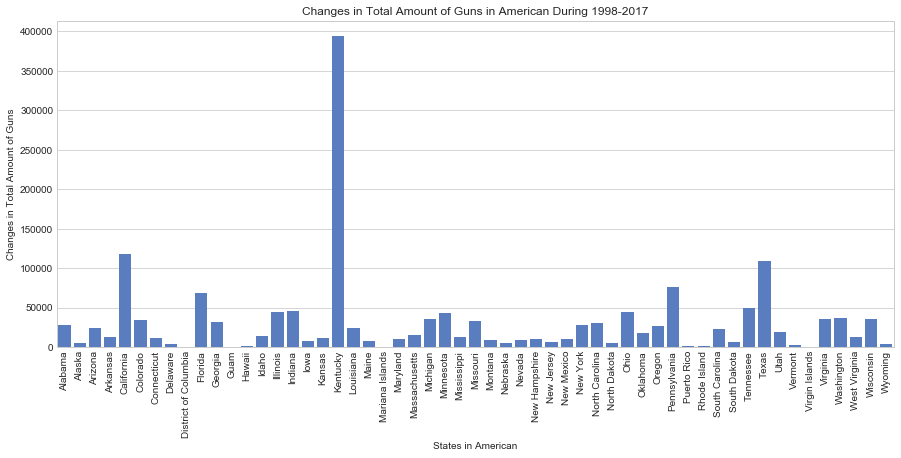

In [59]:
#作图：1998-2017年，美国各州的枪支总量变化量
sns.set_style('whitegrid')
f, ax = plt.subplots(figsize=(15,6))
ax.set_title('Changes in Total Amount of Guns in American During 1998-2017')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.set_color_codes("muted")
sns.barplot(x = 'state_1998',y = 'totals_delta', data=df_gun_delta,color="b")
ax.set(ylabel="Changes in Total Amount of Guns",xlabel="States in American");

从图中，可以看出，Kentucky州的增长量远远超过其他的州，其增长量接近40万支；排在之后的是California州和Texas州，增长量在10万+；其他州的增长量都在10万以下。

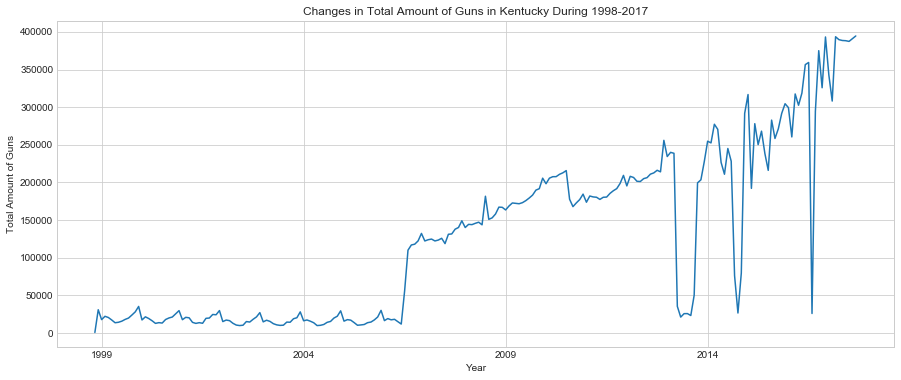

In [60]:
#作图：以时间为横坐标，以Kentucky州的枪支总量为纵坐标，绘出Kentucky州的枪支总量变化曲线
df_gun.query('state == "Kentucky"').plot(df_gun.query('state == "Kentucky"').index, y = 'totals',figsize = (15,6),legend = False,
                                         title = 'Changes in Total Amount of Guns in Kentucky During 1998-2017')
plt.xlabel('Year')
plt.ylabel('Total Amount of Guns');

从图中可以看出，Kentucky州的枪支总量一开始比较稳定，在5万支以下；自2016年之后开始逐年波动上升，可以看出有几个显著的增长区间，分别为2006-2007年、2013-2014年、2014-2015年和2016-2017年。

### 问题 2 在NICS数据统计期间，美国人民购买枪支总量及各种类的趋势是什么？  

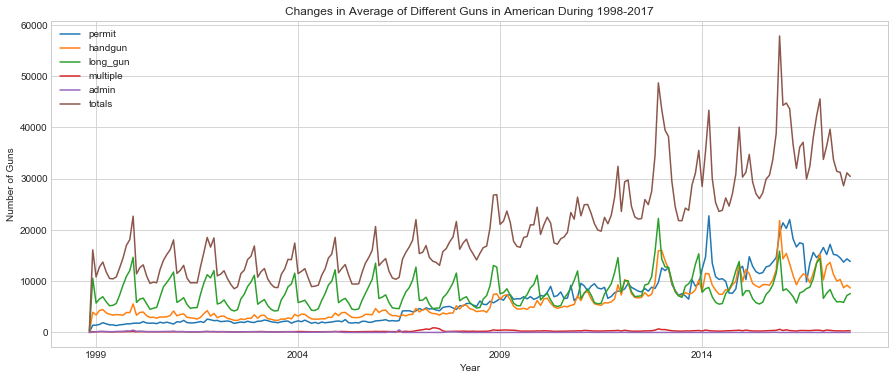

In [61]:
#作图：按时间分组，求出每个统计时间点，全国各州的枪支数量均值，作出时间-枪支数量均值曲线图
df_gun.groupby(df_gun.index).mean().plot(figsize = (15,6),title = 'Changes in Average of Different Guns in American During 1998-2017')
plt.xlabel('Year')
plt.ylabel('Number of Guns');

从图中可以看出，美国的州枪支数量均值呈波动上升趋势，由最开始统计时的不到2万支，增长到3万支左右，并在2016年达到统计区间的峰值（接近6万支），根据趋势图，可以预测出，2018年美国的州枪支数量均值极有可能会再度攀升；针对不同的枪支来说，这些年，美国人民注册用枪量攀升比较迅速，而且逐渐开始偏爱购买手枪；长枪的变化不大，起初在数量上一直高过手枪，但自2014年之后开始出现低于手枪数量的区间,预计未来会落后于手枪的占比。

### 问题3 根据NICS数据，2016年哪个州的人均拥有枪支量最高？

In [62]:
#计算人均拥有枪支量，并添加到df_census_gun_2016中
df_census_gun_2016['Per_capita_possession_of_guns'] = (df_census_gun_2016['totals']/df_census_gun_2016['Population estimates'])

In [63]:
#查看数据
df_census_gun_2016.head()

,state,permit,handgun,long_gun,multiple,admin,totals,Population estimates,"Population estimates base, April 1, 2010, (V2016)","Housing units, July 1, 2016, (V2016)",...,Female persons,White alone,Black or African American alone,American Indian and Alaska Native alone,Asian alone,Native Hawaiian and Other Pacific Islander alone,Two or More Races,Hispanic or Latino,"White alone, not Hispanic or Latino",Per_capita_possession_of_guns
0,Alabama,24253.250000,12760.250000,10163.583333,545.416667,0.416667,47722.916667,4863300.0,"4,780,131",2230185.0,...,2.509463e+06,3.370267e+06,1303364.400,34043.100,68086.200,4863.300,77812.800,2.042586e+05,3.200051e+06,0.009813
1,Alaska,260.083333,3124.250000,3073.916667,193.000000,0.000000,6651.250000,741894.0,"710,249",310658.0,...,3.538834e+05,4.903919e+05,28191.972,112767.888,46739.322,9644.622,54158.262,5.193258e+04,4.540391e+05,0.008965
2,Arizona,7314.250000,13898.666667,9082.333333,659.000000,0.000000,30954.250000,6931071.0,"6,392,301",2961003.0,...,3.486329e+06,5.773582e+06,339622.479,374277.834,235656.414,20793.213,194069.988,2.141701e+06,3.846744e+06,0.004466
3,Arkansas,4621.333333,6687.000000,6843.333333,366.666667,11.916667,18530.250000,2988248.0,"2,916,025",1354762.0,...,1.521018e+06,2.372669e+06,469154.936,29882.480,47811.968,8964.744,59764.960,2.181421e+05,2.178433e+06,0.006201
4,California,86415.083333,46696.250000,46212.500000,0.000000,0.000000,179323.833333,39250017.0,"37,254,522",14060525.0,...,1.974276e+07,2.853476e+07,2551251.105,667250.289,5809002.516,196250.085,1491500.646,1.526826e+07,1.479726e+07,0.004569


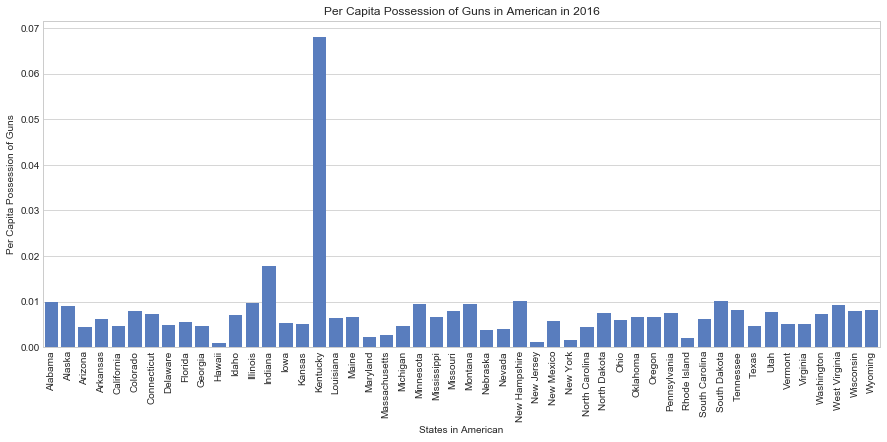

In [64]:
#作图：以各州为横坐标，人均持枪量为纵坐标绘制2016年美国各州人均持枪量柱状图
f, ax = plt.subplots(figsize=(15,6))
ax.set_title('Per Capita Possession of Guns in American in 2016')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
sns.barplot(x = 'state',y = 'Per_capita_possession_of_guns', data=df_census_gun_2016,color="b")
ax.set(ylabel="Per Capita Possession of Guns",xlabel="States in American");

显然，Kentucky州又以人均接近0.07支枪的数据遥遥领先于国内其他州；其次是Indiana州，有接近0.02的人均持枪量，其他各州的人均持枪量则在0.01附近或以下。

### 问题4 结合2016年各州的人口普查数据，是否有哪项数据与人均拥有枪支量高度相关？

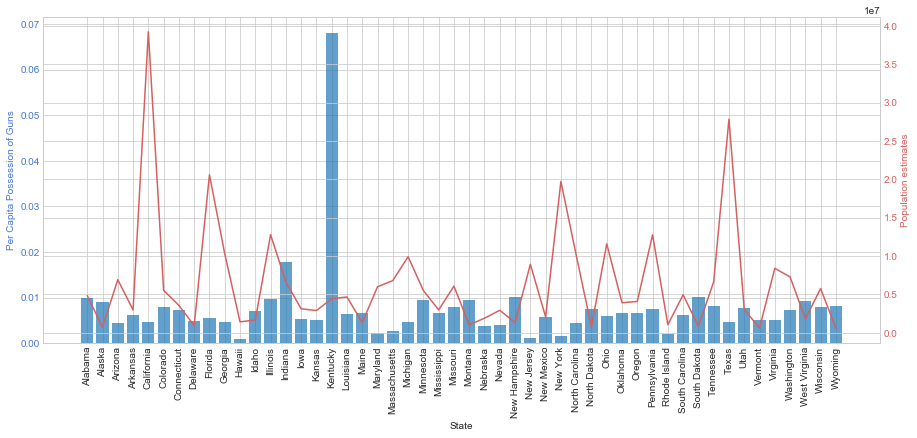

In [65]:
#作图，以美国各州为横坐标，分别绘制与人均持枪量的柱状图（蓝色）和人口总量的折线图（红色）
fig, ax1 = plt.subplots(figsize = (15,6))

ax1.bar(df_census_gun_2016['state'],df_census_gun_2016['Per_capita_possession_of_guns'], alpha=0.7)
ax1.set_xlabel('$x$')

# Make the y-axis label and tick labels match the line color.
ax1.set_ylabel('Per Capita Possession of Guns', color='b')
[tl.set_color('b') for tl in ax1.get_yticklabels()]

#Set up ax2 to be the second y axis with x shared
ax2 = ax1.twinx()
#Plot a line
ax2.plot(df_census_gun_2016['state'],df_census_gun_2016['Population estimates'], 'r-')

# Make the y-axis label and tick labels match the line color.
ax2.set_ylabel('Population estimates', color='r')
[tl.set_color('r') for tl in ax2.get_yticklabels()]
ax1.set_xticklabels(df_census_gun_2016['state'], rotation=90)
ax1.set(xlabel = 'State');


从图中可以看出，California州的人口总数最高，但是人均持枪量很低；反观Kentucky州人均持枪量很高，但人口数量并不多。（所以说Kentucky州的人都是“社会哥”？！）总体来说，人均持枪量与人口总数基本无关。

其他人口普查数据与人均持枪量的关系图可以同理绘出，先查看他们之间的相关系数，然后再画出相关系数大于0.5的那个。

In [69]:
#求出人口普查各项数据与人均持枪量的相关系数
df_census_gun_2016.corr()['Per_capita_possession_of_guns']

permit                                              0.893994
handgun                                             0.019090
long_gun                                           -0.003349
multiple                                            0.077818
admin                                              -0.001428
totals                                              0.718868
Population estimates                               -0.102052
Housing units,  July 1, 2016,  (V2016)             -0.098705
Building permits, 2016                             -0.105194
Population change                                  -0.088566
Persons under 5 years                              -0.043034
Persons under 18 years                             -0.043379
Persons 65 years and over                          -0.039975
Female persons                                     -0.044302
White alone                                        -0.022937
Black or African American alone                    -0.087223
American Indian and Alas

很尴尬，并没有任何一项能与人均持枪量高度相关。人均持枪量可能会与当地的黑帮数量、警察数量、犯罪率高度相关。

<a id='conclusions'></a>
## 结论

 **问题解答**：  
 - 1，就1998-2017年统计的数据而言，Kentucky州的枪支总量增长最高，该州的增长速率成波动上升趋势，并且有几个明显的跃升点； 
 - 2，美国人民购买枪支总量的趋势也是波动上升，而且注册枪支和手枪数量逐年上升，但长枪的数量基本稳定；
 - 3，2016年Kentucky州的人均拥有枪支量最高，大约每100个人中就有7支枪；  
 - 4，结合2016年各州的人口普查数据，并没有发现哪项数据与人均拥有枪支量高度相关，反而各项数据与人均持枪量无关。

**不足**：人口普查数据只有2016年统计的比较全面，只对2016年各州的数据进行了横向比较，而没有对美国在不同年份的数据进行纵向比较。
